In [4]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

# Map of NYC cencus tract

In [3]:
import folium

data = pd.read_csv('../data/processed/nyc_processed_2017_to_2019_20210225.csv',dtype={'census_tract_GEOID':'object'})
# print(data.columns)

nyc_geo = f'../data/geo/nyc_2010_tracts_formatted.geojson'
# import json
# with open(nyc_geo) as f:
#     gj = json.load(f)
# print(gj['features'][0])

col_name = 'ratio-to-mean-eviction-rate'
data[col_name] = data[col_name].replace(np.inf,np.NaN)
bins = list(data[col_name].quantile([0, 0.25, 0.5, 0.75, 1]))
nyc_map = folium.Map(location=[40.730610, -73.935242],zoom_start=10)

folium.Choropleth(
    geo_data=nyc_geo,
    name='choropleth',
    data=data,
    columns=['census_tract_GEOID', col_name],
    key_on='feature.properties.census_tract_GEOID', # Use 'feature', not 'features'. this seems to be a bug
    bins = bins,
    legend_name=col_name,
    fill_color='RdBu',
    fill_opacity=0.7,
    line_opacity=0.2
).add_to(nyc_map)

folium.LayerControl().add_to(nyc_map)

# nyc_map

# nyc_map.save('../../plots/nyc_map_'+col_name+'.html')

# Time series of evictions

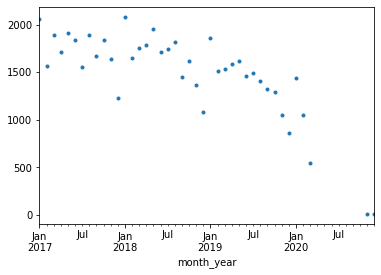

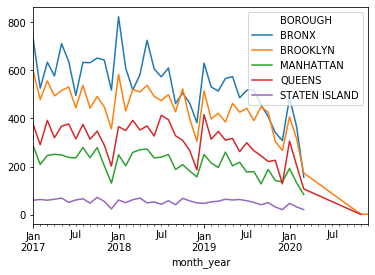

In [4]:
filename = 'nyc_evictions_geocoded' # nyc_evictions_present
data = pd.read_csv('../data/raw/'+filename +'.csv')
data['EXECUTED_DATE'] = pd.to_datetime(data['EXECUTED_DATE'])
data = data.drop(data['EXECUTED_DATE'].idxmax()) # one record that has an executed date in 2070
data['month_year'] = data['EXECUTED_DATE'].dt.to_period('M')
data.groupby('month_year').size().plot(style='.')
data.groupby(['month_year','BOROUGH']).size().unstack().plot()

Dip in December, but bounce back in January. Sharp drop in 2019. No data for most of 2020. Why? Policy change or incomplete data?

Notes: 
- Raw eviction data from NYC (https://data.cityofnewyork.us/City-Government/Evictions/6z8x-wfk4) are downloaded and stored in raw/nyc_evictions_present.csv. There is not much different from the geocoded data provided. Only a few new records in 2021.
- The eviction with court_index_number 28748/16  has an executed date in 2070.  


# Evictions of school districts

In [6]:
# From dgillen with modification

import geopandas

sd = geopandas.read_file('../data/geo/nyc_school_districts.geojson')
data = pd.read_csv('../data/raw/nyc_evictions_geocoded.csv')
data[['lon','lat']] = data['lon_lat'].str.split(',',expand = True)
data = geopandas.GeoDataFrame(data,geometry=geopandas.points_from_xy(data.lon,
                                            data.lat, crs=sd.crs))
data = geopandas.sjoin(data,sd,op='within',how='left')
# data.columns

sd_data = data.groupby('school_dist').size().reset_index()
sd_data.columns = ['school_dist','total_evictions']

In [12]:
import plotly
import plotly.express as px

import json
with open('../data/geo/nyc_school_districts.geojson') as json_file:
    sdGeoJson = json.load(json_file)
# print(sdGeoJson['features'][0])

mean_lon, mean_lat = -73.93865, 40.788143

sd_map = px.choropleth_mapbox(sd_data, 
              geojson=sdGeoJson, 
              color="total_evictions",
              color_discrete_sequence = px.colors.qualitative.Dark24,
              locations="school_dist", 
              featureidkey="properties.school_dist",
              opacity=0.5,
              center={"lat": mean_lat ,"lon": mean_lon},
              mapbox_style="streets",
              height=1000,
              title = "Number of Evictions by School District",
              # margin={"r":0,"t":40,"l":0,"b":0,'pad':15},
              zoom=9)
#sd_map.update_layout(mapbox_accesstoken='pk.eyJ1IjoiZGdpbGxlbiIsImEiOiJjam85OGFvaXIxZXRlM2tubG8zY3E0OHh1In0.KkjAoFhjOOFjXAEuZ1IRog')   

# sd_map.show()
# sd_map.write_html('../../plots/nyc_school_districts.html')

# Total evictions for each census tract

In [114]:
data = pd.read_csv('../data/raw/nyc_evictions_geocoded.csv')
data = data.dropna(subset=['tract_code'])

# Make column census_tract_GEOID
# From eyelverton with modification
# Convert to strings
data["state_code"] = data["state_code"].astype(str).replace(r'\.0', '', regex = True)  
data["county_code"] = data["county_code"].astype(str).replace(r'\.0', '', regex = True)  
data["tract_code"] = data["tract_code"].astype(str).replace(r'\.0', '', regex = True)
# Add zeroes as necessary
data["state_code"] = data["state_code"].apply(lambda x: (((2-len(x)) * "0") + x) 
                                                        if len(x) < 2 else x)
data["county_code"] = data["county_code"].apply(lambda x: (((3-len(x)) * "0") + x) 
                                                        if len(x) < 3 else x)
data["tract_code"] = data["tract_code"].apply(lambda x: (((6-len(x)) * "0") + x) 
                                                        if len(x) < 6 else x)
# Finally, concat everything
data["census_tract_GEOID"] = data["state_code"] + data["county_code"] + data["tract_code"]

evi = data.groupby('census_tract_GEOID').size().reset_index()
evi.columns = ['GEOID','total_evictions']

# Percentage of no matching tract_code in BOROUGH or EVICTION_ZIP

In [179]:
data = pd.read_csv('../data/raw/nyc_evictions_geocoded.csv')

print(data['match_indicator'].value_counts())

area = 'EVICTION_ZIP' # BOROUGH or EVICTION_ZIP

no_match = data[area][data['tract_code'].isna()].value_counts().reset_index()
stat = data[area].value_counts().reset_index().merge(no_match,how='left',on='index')
stat = stat.fillna(0)
stat['pct'] = stat[area+'_y']/stat[area+'_x']*100
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
#     print(stat)

Match       55459
No_Match     4771
Tie           558
Name: match_indicator, dtype: int64


The percentage varies a lot among different zip codes, which will definitely affect the accuracy of predictive models.

Notes
- Out of the 60788 evictions in NYC raw data, 4771 don’t have matching addresses and 558 have tie matching addresses, which give 5329 (~8.8%) that don’t have 'tract_code' and 55459 that have 'tract_code'. 

In [181]:
!ls ../data/acs

data_dictionary.csv               nyc_acs5-2018_census.csv
hillsborough_acs5-2018_census.csv
